In [188]:
from langchain_openai import OpenAIEmbeddings
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from langchain_core.prompts import ChatPromptTemplate
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langgraph.graph import START, END, StateGraph
from typing import List, TypedDict
from CONFIG import OPENAI_EMBEDDED_MODEL, GROQ_MODEL
from langchain_community.vectorstores import FAISS
import re
from pydantic import BaseModel

In [189]:
load_dotenv()
llm = ChatGroq(model=GROQ_MODEL)
embedded_model = OpenAIEmbeddings(model=OPENAI_EMBEDDED_MODEL)

In [190]:
class state(TypedDict):
    question: str
    doc: List[str]

    strip: List[str]
    refined_strip: List[str]
    refined_text: str
    
    answer: str

In [191]:
pdf_loading = PyPDFLoader(file_path='A:\AI_Projects_Practice\CRAG\The_Evolution_of_AI_in_Dubai.pdf')
pdf = pdf_loading.load()
len(pdf)

8

In [192]:
splitting = RecursiveCharacterTextSplitter(chunk_size=400, chunk_overlap=100).split_documents(pdf)
len(splitting)

56

In [193]:
vector_storage = FAISS.from_documents(splitting, embedded_model)

In [194]:
retrieved = vector_storage.as_retriever(search_type='similarity', search_kwargs={'k': 2})
for i in retrieved.invoke('dubai'):
    print(i.page_content)
    print('*'*100)

boosting the economy, and improving quality of life for residents and visitors.
Key components of this strategy include:
Infrastructural Development: Dubai is investing in tech infrastructure to support AI-driven
services. This entails deploying high-speed internet and cloud computing resources across the
city.
****************************************************************************************************
Dubai AI Strategy: Introduced in 2017, this strategy aims to make Dubai a global hub for AI by
2031. It focuses on utilizing AI to optimize government operations, improve city services, and
advance economic development. It involves collaboration between governmental bodies and
private sectors to create an ecosystem that fosters AI innovation.
****************************************************************************************************


In [195]:
def retrieved_node(state):
    q = state['question']
    return {'doc': retrieved.invoke(q)}

In [196]:
def decompose_to_sentence(text: str) -> List[str]:
    text = re.sub(r"\s+", " ", text).strip()
    sentence = re.split(r"(?<=[.!?])\s+", text)
    return [s.strip() for s in sentence if len(s.strip()) > 20]

# decompose_to_sentence("""
# Dubai AI Strategy: Introduced in 2017, this strategy aims to make Dubai a global hub for AI by
# 2031. It focuses on utilizing AI to optimize government operations, improve city services, and
# advance economic development. It involves collaboration between governmental bodies and
# private sectors to create an ecosystem that fosters AI innovation.
# """)

In [197]:
class KeepOrDrop(BaseModel):
    keep: bool

filter_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "you are a strict relevence filter.\n"
            "Return BOOLEAN, keep=true only if the sentence directly helps answer the question,\n"
            "Use only the sentence, output in JSON format only."
	  ),
	  (
		"human",
		"Question: {question}\n\n"
		"Sentence: {sentence}\n"
	  ),
    ]
)

filter_chain = filter_prompt | llm.with_structured_output(KeepOrDrop)

In [198]:
def refined(state: state):
    q = state['question']

    # Conbined the text
    context = "\n\n".join(d.page_content for d in state['doc'])

    # DECOMPOSITION
    striped = decompose_to_sentence(context)

    # FILTERED
    kept: List[str] = []
    for s in striped:
        if filter_chain.invoke({'question': q, 'sentence': s}).keep:
            kept.append(s)
            
    # RECOMPOSITION
    refined_context = '\n'.join(kept).strip()

    return {
        'strip': striped,
    	  'refined_strip': kept,
        'refined_text': refined_context
    }

In [199]:
prompt = ChatPromptTemplate(
    [
        ("system", "Answer only from the context. If not in context, say you don't know."),
        ("human", "Question is: {question}\n\nContext is: {context}")
    ]
)

def generate_node(state):
    question = state['question']
    context = state['refined_text']
    out = (prompt|llm).invoke(
        {
            "question": question,
            "context": context
	  }
    )

    return {'answer':out.content}

In [200]:
graph = StateGraph(state)

graph.add_node('retrieved_node', retrieved_node)
graph.add_node('refined', refined)
graph.add_node('generate_node', generate_node)

graph.add_edge(START, 'retrieved_node')
graph.add_edge('retrieved_node', 'refined')
graph.add_edge('refined', 'generate_node')
graph.add_edge('generate_node', END)

crag = graph.compile()

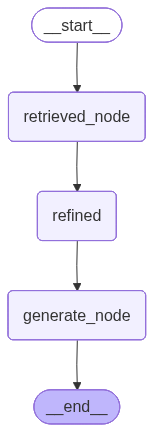

In [201]:
crag

In [206]:
output = crag.invoke(
    {
        'question': 'AI in Dubai',
        'doc': [],
        'answer': '',
        'strip': [],
    	  'refined_strip': [],
    	  'refined_text': ''
    }
)

In [207]:
print(output['answer'])

In Dubai, AI is being used in various sectors, including healthcare, where the Dubai Health Authority has implemented AI-driven diagnostics like IBM's Watson to improve patient care. Dubai's AI development is also supported by a robust infrastructure that includes data centers, cloud platforms, and network capabilities.


In [208]:
output

{'question': 'AI in Dubai',
 'doc': [Document(id='f5239cd6-ea51-4ab2-b079-0b71a4289aad', metadata={'producer': 'Skia/PDF m144', 'creator': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/144.0.0.0 Safari/537.36 Edg/144.0.0.0', 'creationdate': '2026-02-09T17:29:23+00:00', 'title': 'Untitled', 'moddate': '2026-02-09T17:29:23+00:00', 'source': 'A:\\AI_Projects_Practice\\CRAG\\The_Evolution_of_AI_in_Dubai.pdf', 'total_pages': 8, 'page': 0, 'page_label': '1'}, page_content='integration.\nAI Infrastructure Development in Dubai\nDubai’s rapid AI development is anchored by robust infrastructure that facilitates various applications\nacross multiple sectors. This infrastructure includes data centers, cloud platforms, and network\ncapabilities, which are essential for supporting AI initiatives.'),
  Document(id='d2e270fa-8cbf-442a-bad2-d255f092be2b', metadata={'producer': 'Skia/PDF m144', 'creator': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/5

In [219]:
for d in output['doc']:
    print(d.page_content)
    print('*'*100)

integration.
AI Infrastructure Development in Dubai
Dubai’s rapid AI development is anchored by robust infrastructure that facilitates various applications
across multiple sectors. This infrastructure includes data centers, cloud platforms, and network
capabilities, which are essential for supporting AI initiatives.
****************************************************************************************************
AI in Healthcare: The Dubai Health Authority has implemented AI-driven diagnostics, such as
IBM's Watson, to enhance patient care. These systems analyze large datasets to assist healthcare
professionals in developing personalized treatment plans. Performance is improved through
reduced diagnosis times, although it is essential to monitor accuracy and ensure that AI
****************************************************************************************************


In [223]:
for r in output['strip']:
    print(r)
    print('*'*170)

AI Infrastructure Development in Dubai Dubai’s rapid AI development is anchored by robust infrastructure that facilitates various applications across multiple sectors.
**************************************************************************************************************************************************************************
This infrastructure includes data centers, cloud platforms, and network capabilities, which are essential for supporting AI initiatives.
**************************************************************************************************************************************************************************
AI in Healthcare: The Dubai Health Authority has implemented AI-driven diagnostics, such as IBM's Watson, to enhance patient care.
**************************************************************************************************************************************************************************
These systems analyze large datasets to assist heal

In [224]:
for rs in output['refined_strip']:
    print(rs)
    print('*'*170)

AI Infrastructure Development in Dubai Dubai’s rapid AI development is anchored by robust infrastructure that facilitates various applications across multiple sectors.
**************************************************************************************************************************************************************************
This infrastructure includes data centers, cloud platforms, and network capabilities, which are essential for supporting AI initiatives.
**************************************************************************************************************************************************************************
AI in Healthcare: The Dubai Health Authority has implemented AI-driven diagnostics, such as IBM's Watson, to enhance patient care.
**************************************************************************************************************************************************************************


In [227]:
print(output['answer'])

In Dubai, AI is being used in various sectors, including healthcare, where the Dubai Health Authority has implemented AI-driven diagnostics like IBM's Watson to improve patient care. Dubai's AI development is also supported by a robust infrastructure that includes data centers, cloud platforms, and network capabilities.
